In [1]:
# Get metadata object
import json
meta_data_file_path = "/fb-agios-acai-efs/Ego4D/ego4d_data/ego4d.json"

with open(meta_data_file_path, 'r') as meta_data_file:
    meta_data_obj = json.load(meta_data_file)

In [ ]:
l1_keys = [k for k in meta_data_obj.keys()]
print(f"L1={l1_keys}")

for l1_key in l1_keys:
    child = meta_data_obj[l1_key]
    if isinstance(child, dict):
        print(f"L2={l1_key}:{list(subdict.keys())}")
    elif isinstance(child, list) and isinstance(child[0],dict):
        print(f"L2={l1_key}:{list(child[0].keys())}")
print(f"we are interested in linking per-user with 'fb_participant_id' in 'videos'")

In [ ]:
# Collect videos stats
from collections import defaultdict
videos = meta_data_obj['videos']

def percent_str(num,denom):
    return "{:.1f}%".format(num/denom*100)

def nb_format(el_list,d=2):
    fmt = f'{{:.{d}f}}'
    return list(map(
        lambda x: float(fmt.format(x)) if isinstance(x,float) else x,
    el_list))
    
class UserData:
    def __init__(self):
        self.videos = []
   
# Collect vids per user
user_dict = defaultdict(UserData)
for video in videos:
    user_id = str(video['fb_participant_id']) # Can be null
    user_dict[user_id].videos.append(video)

total_nb_videos = len(videos)

# Extract NULL user (unassigned)
non_int_users = []
for user_id in user_dict.keys():
    try:
        int(user_id)
    except:
        non_int_users.append(user_id)
print(f"NON-INT USERS: {non_int_users} -> Assumed unassigned")
for non_int_user in non_int_users:
    print(f"UNKOWN USER VIDEOS: {user_video_count[non_int_user]}/{total_nb_videos} ({percent_str(user_video_count[non_int_user],total_nb_videos)})")

nb_users = len(user_dict.keys()) - len(non_int_users)
print(f"NB of USERS: {nb_users}")
    

In [ ]:
# PLOT VIDEOS PER USER
# Barchart API: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html#matplotlib.pyplot.bar
import matplotlib.pyplot as plt

def plot_barchart(x_axis, sorted_freq, title,ylabel,xlabel='User-ID', grid=False):
    max_val = max(sorted_freq)
    my_cmap = plt.get_cmap("plasma")
    plt.figure(figsize=(12, 6), dpi=80)
    plt.bar(x_axis, height=sorted_freq,color=my_cmap.colors)
    plt.ylim(None,max_val*1.01)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(grid)
    plt.show()
    plt.clf()
    
    print(f"HEAD = {nb_format(sorted_freq[:10])}...")
    print(f"TAIL = ...{nb_format(sorted_freq[-10:])}")
    
# Sorted Histogram
# Get user counts
def get_derived_distrs(counts):
    """ Return sorted, PDF, CDF"""
    counts_sorted = sorted(counts,reverse=True) # Sorted
    
    # Pdf
    total_video_count = sum(counts_sorted)
    pdf = [cnt/total_video_count for cnt in counts_sorted] # Sorted and normalized
    
    # Cdf
    cdf = [pdf[0]]
    for x in pdf[1:]:
        cdf.append(cdf[-1]+x)
    
    return counts_sorted, pdf, cdf
    
user_video_count = [len(u.videos) for u in user_dict.values()]
user_video_count_s, user_video_count_sn, user_video_count_snc = get_derived_distrs(user_video_count)


x_axis = [idx for idx in range(len(user_video_count_s))]

# Counts
plot_barchart(x_axis, user_video_count_s, title='Freq of vids per User-ID',ylabel='Freq')
# plot_barchart(user_video_count_s[1:])
print(f"First user is the unassigned one!")


# Normalized
plot_barchart(x_axis, user_video_count_sn,  title='Fraction of vids per User-ID',ylabel='fraction')
print(f"Unassigned is 15%, highest user fraction is only nearly 2%")

# Cumulative
plot_barchart(x_axis, user_video_count_snc,title='CDF of vids per User-ID',ylabel='CDF', grid=True)
print(f"About 60% of the videos is from the first 100 users")
print(f"About 80% of the videos is from the first 200 users")


In [ ]:
# Now let's do the same without the unassigned videos

# Renew devision factor
excl_user_video_count = user_video_count[1:]
excl_x_axis = x_axis[:-1]
user_video_count_s, user_video_count_sn, user_video_count_snc = get_derived_distrs(excl_user_video_count)

# Histogram
plot_barchart(excl_x_axis, user_video_count_s, title='Freq of vids per User-ID',ylabel='Freq')

# Normalized
plot_barchart(excl_x_axis, user_video_count_sn,  title='Fraction of vids per User-ID',ylabel='fraction')
print(f"Unassigned is 15%, highest user fraction is only nearly 2%")

# Cumulative
plot_barchart(excl_x_axis, user_video_count_snc,title='CDF of vids per User-ID',ylabel='CDF', grid=True)


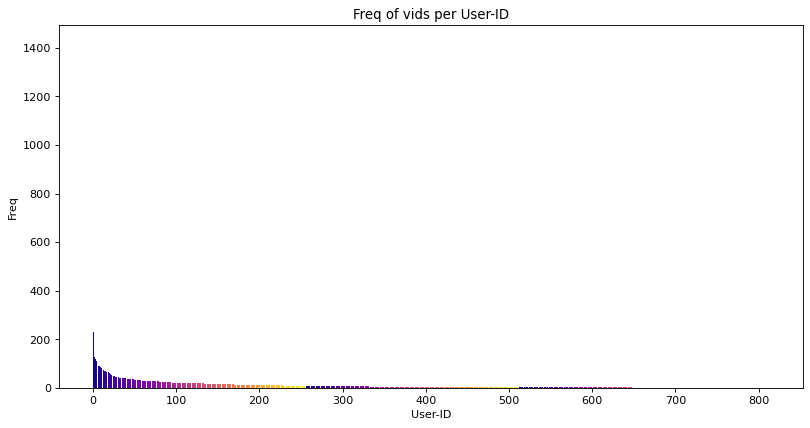

HEAD = [1478, 229, 125, 117, 110, 100, 95, 90, 89, 86]...
TAIL = ...[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


<Figure size 432x288 with 0 Axes>

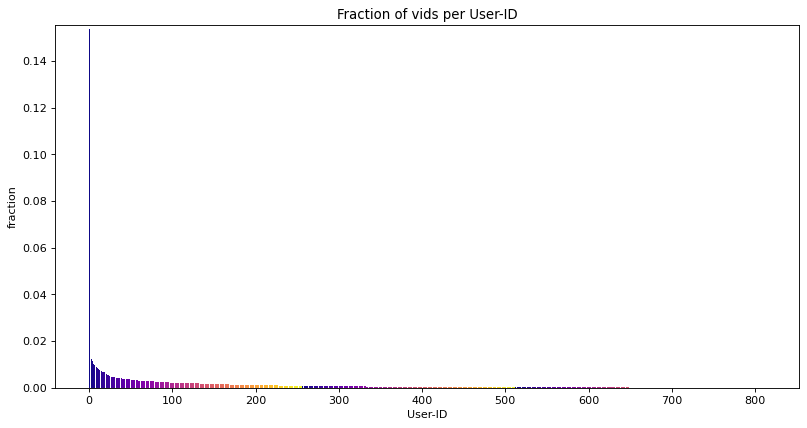

HEAD = [0.15, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]...
TAIL = ...[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Unassigned is 15%, highest user fraction is only nearly 2%


In [ ]:
# Now let's do the same without the unassigned videos

# Renew devision factor
excl_user_video_count = user_video_count[1:]
excl_x_axis = x_axis[:-1]
user_video_count_s, user_video_count_sn, user_video_count_snc = get_derived_distrs(excl_user_video_count)

# Histogram
plot_barchart(excl_x_axis, user_video_count_s, title='Freq of vids per User-ID',ylabel='Freq')

# Normalized
plot_barchart(excl_x_axis, user_video_count_sn,  title='Fraction of vids per User-ID',ylabel='fraction')
print(f"Unassigned is 15%, highest user fraction is only nearly 2%")

# Cumulative
plot_barchart(excl_x_axis, user_video_count_snc,title='CDF of vids per User-ID',ylabel='CDF', grid=True)
